In [1]:
sys.path.append(r'../atm_demand')
from forecasting import *
from feature_generation import *
from plotting import *

import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("../atm_demand/DATA_sample_atm.csv")
targets = ['CashIn', 'CashOut']
atm_df = get_atm(df, 26637)
atm_df = atm_df[:-135]
atm_df[atm_df<1] = 1
atm_df = clean_data(atm_df, drop_zeros=False)

<AxesSubplot:xlabel='HistoryDate'>

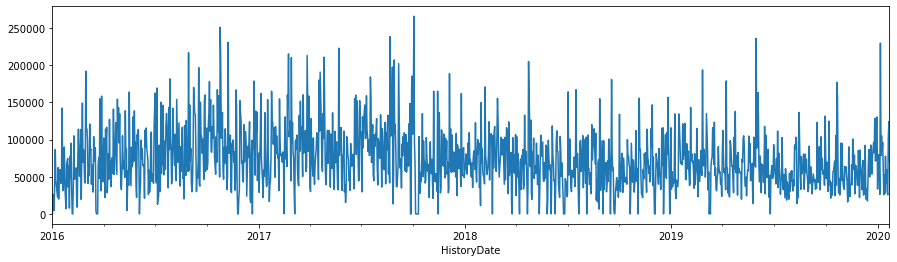

In [3]:
atm_df['CashIn'].plot(figsize=(15,4))

In [4]:
class RNN(tf.Module):
    
    def __init__(self, state_size, batch_size, to_many=False, **kwargs):
        super().__init__(**kwargs)

        self.to_many = to_many

        # for calculating the next state
        self.w1 = tf.Variable(np.random.rand(state_size + 1, state_size), dtype=tf.float64)
        self.b1 = tf.Variable(np.random.rand(1), dtype=tf.float64)

        # for calculating output
        self.w2 = tf.Variable(np.random.rand(state_size, 1), dtype=tf.float64)
        self.b2 = tf.Variable(np.random.rand(1), dtype=tf.float64)

        self.states = tf.Variable(np.ones((batch_size, state_size)), shape=(batch_size, state_size))

    # calculate output from current state
    # calcualte next state from current state + input
    # input shap: [batch_size, 1]
    def __call__(self, x):
        input_state_stacked = tf.concat([x, self.states], axis=1)
        output = tf.matmul(self.states, self.w2) + self.b2
        self.states = tf.sigmoid(tf.matmul(input_state_stacked, self.w1) + self.b1)
        return tf.tanh(output)

    def run_batch(self, batch):
        y_preds = []

        for i in range(batch.shape[1]):
            y_preds.append(self(batch[:, i, None]))

        return tf.concat((y_preds if self.to_many else [y_preds[-1]]), axis=1)

    def __str__(self):
        return " ".join([str(i) for i in self.state.numpy()])

In [5]:
# x: batch of sequences (batch_size, sequence length)
def train(model, batch, y_actual, learning_rate):
    with tf.GradientTape() as tape:
        
        y_pred = model.run_batch(batch)

        current_loss = tf.reduce_mean(tf.square(y_pred - y_actual))

        d_w1, d_b1, d_w2, d_b2 = tape.gradient(current_loss, [model.w1, model.b1, model.w2, model.b2])

        model.w1.assign_sub(learning_rate * d_w1)
        model.b1.assign_sub(learning_rate * d_b1)
        model.w2.assign_sub(learning_rate * d_w2)
        model.b2.assign_sub(learning_rate * d_b2)

    return current_loss.numpy()

In [6]:
# Define a training loop
def training_loop(model, x_train, y_train, epochs, learning_rate, val_set=None, print_every = 1):

    train_losses = []
    test_losses  = []
    for epoch in range(epochs):
        batch_train_losses = []
        batch_val_losses  = []
        for batch in range(x_train.shape[0]):
            # Update the model with the single giant batch
            train_loss = train(model, x_train[batch], y_train[batch], learning_rate)
            batch_train_losses.append(train_loss)

        if val_set != None:
            x_val, y_val = val_set
            for batch in range(x_val.shape[0]):
                y_pred  = model.run_batch(x_val[batch])
                batch_val_losses.append(np.mean((y_pred - y_val[batch])**2))

        loss_average = lambda l: sum(l)/len(l)
        epoch_train_loss = loss_average(batch_train_losses)
        train_losses.append(epoch_train_loss)
        epoch_val_loss = loss_average(batch_val_losses)
        test_losses.append(epoch_val_loss)

        if epoch%print_every == 0 or epoch == epochs-1:
            print("Epoch %d: train loss=%.5f, test loss=%.5f" % (epoch, epoch_train_loss, epoch_val_loss))

    return train_losses, test_losses


In [7]:
SEQUENCE_LENGHT = 10
BATCH_SIZE = 50
N_EPOCH = 1000

N_STATES = 10
TARGET = 'CashIn'

windows = get_windows(atm_df[TARGET], SEQUENCE_LENGHT)
windows_reversed = windows[windows.columns[::-1]]

scaler = StandardScaler()
scaler = scaler.fit(windows_reversed)
windows_normal = scaler.transform(windows_reversed)
# normalize_with = windows_reversed[windows_reversed.columns[0]]
# windows_normal = windows_reversed.divide(normalize_with, axis = 'index') # normalize
#windows_np = windows_normal.to_numpy()

n_batches = windows_normal.shape[0] // BATCH_SIZE
X = windows_normal[:n_batches * BATCH_SIZE, :SEQUENCE_LENGHT].reshape(n_batches, BATCH_SIZE, SEQUENCE_LENGHT)
X = tf.constant(X, dtype = tf.dtypes.float64)

y = windows_normal[:n_batches*BATCH_SIZE, -1].reshape(n_batches, BATCH_SIZE, 1)
y = tf.constant(y, dtype = tf.dtypes.float64)

rnn = RNN(N_STATES, BATCH_SIZE)

In [8]:
SPLIT = 0.2
split_index = int(X.shape[0] * SPLIT)

x_train = X[split_index:]
y_train = y[split_index:]
x_val  = X[:split_index]
y_val  = y[:split_index]

In [9]:
train_errors, test_errors = training_loop(rnn, x_train, y_train, N_EPOCH, 0.05, print_every=50, val_set=(x_val, y_val))

Epoch 0: train loss=2.00708, test loss=1.94639
Epoch 50: train loss=2.00703, test loss=1.94634
Epoch 100: train loss=2.00692, test loss=1.94623
Epoch 150: train loss=2.00619, test loss=1.94552
Epoch 200: train loss=0.96621, test loss=1.15783
Epoch 250: train loss=0.96613, test loss=1.15772
Epoch 300: train loss=0.96603, test loss=1.15757
Epoch 350: train loss=0.96590, test loss=1.15739
Epoch 400: train loss=0.96575, test loss=1.15715
Epoch 450: train loss=0.96554, test loss=1.15682
Epoch 499: train loss=0.96526, test loss=1.15638


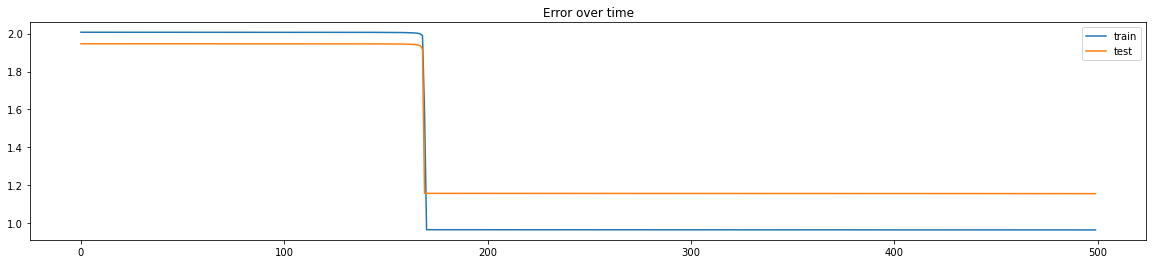

In [11]:
plt.figure(figsize=(20,4))
plt.plot(train_errors, label = 'train')
plt.plot(test_errors, label = 'test')
plt.legend()
plt.title("Error over time")
plt.show()